In [1]:
from google.colab import drive
drive.mount('/content/drive')

ValueError: mount failed

In [ ]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/Cooking_Dataset/Cooking_Dataset/train.csv")
for x in range(len(df['Recipe'])):
    if type(df['Recipe'][x]) != str:
        print(df['Recipe'][x])
        df['Recipe'][x] = ''

df = df[0:5000]

file_path = ""

# MAX_LENGTH = df['Ingredients'].str.len().max()
MAX_LENGTH = 150
print("Maximum length of strings in 'Ingredients' column:", MAX_LENGTH)
with open("eng-fra.txt", "w") as file:
    for index, row in df.iterrows():
        file.write(f"{row['Recipe']}:::{row['Ingredients']}\n")

SOS_token = 0
EOS_token = 1
class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1


def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s


def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    file_name = file_path + 'eng-fra.txt'
    lines = open(file_name, encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split(':::')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)
def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

nan
nan
Maximum length of strings in 'Ingredients' column: 150
Reading lines...
Read 5000 sentence pairs
Trimmed to 4180 sentence pairs
Counting words...
Counted words:
fra 3919
eng 6809
[' ea quart jar or c dill seeds ea prepared tray water to times seeds', 'soak for hours . rinse times daily for to days . move into sunlight to green . harvest when sprouts are to inches long . use in salads sandwiches and juices .']


In [ ]:
import torch
import torch.nn as nn

class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, additional_layers=4):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.additional_layers = additional_layers

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size,2)

        # Additional fully connected layers
        self.additional_fcs = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(additional_layers)])

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output, hidden = self.lstm(embedded, hidden)

        # Pass the output through additional fully connected layers
        for fc in self.additional_fcs:
            output = fc(output)
            output = torch.relu(output)  # You can use other activation functions as well

        return output, hidden

    def initHidden(self):
        return (torch.zeros(1, 1, self.hidden_size, device=device),
                torch.zeros(1, 1, self.hidden_size, device=device))

class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, additional_layers=4):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.additional_layers = additional_layers

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size,2)

        # Additional fully connected layers
        self.additional_fcs = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(additional_layers)])

        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = torch.relu(output)
        output, hidden = self.lstm(output, hidden)

        # Pass the output through additional fully connected layers
        for fc in self.additional_fcs:
            output = fc(output)
            output = torch.relu(output)  # You can use other activation functions as well

        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return (torch.zeros(1, 1, self.hidden_size, device=device),
                torch.zeros(1, 1, self.hidden_size, device=device))


In [1]:
teacher_forcing_ratio = 1
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break
    loss.backward()
    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

NameError: name 'MAX_LENGTH' is not defined

In [ ]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [ ]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    dll = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every
    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    dev_pairs2 = [tensorsFromPair(random.choice(dev_pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()
    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]
        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss
        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))
            # Calculate development loss
            dl = 0
            with torch.no_grad():
              for d in dev_pairs2:
                input_tensor = d[0]
                target_tensor = d[1]
                loss2 = evaluate2(input_tensor, target_tensor, encoder, decoder,criterion)
                dl += loss2
            dl / len(dev_pairs2)
            dl_avg = dl / len(dev_pairs2)
            dll.append((iter, dl_avg))
            print('Dev Loss is: %.4f' % dl_avg)
        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append((iter, plot_loss_avg))
            plot_loss_total = 0
    showPlot(plot_losses, dll)

In [ ]:
def evaluate_loss(input_tensor, target_tensor, encoder, decoder, criterion):
    with torch.no_grad():
        encoder_hidden = encoder.initHidden()
        input_length = input_tensor.size(0)
        target_length = target_tensor.size(0)
        encoder_outputs = torch.zeros(MAX_LENGTH, encoder.hidden_size, device=device)
        loss = 0
        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] = encoder_output[0, 0]
        decoder_input = torch.tensor([[SOS_token]], device=device)
        decoder_hidden = encoder_hidden
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input
            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break
    return loss.item() / target_length

In [ ]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np
%matplotlib inline

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [ ]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words

2m 32s (- 10m 11s) (1000 20%) 6.2999
5m 1s (- 7m 32s) (2000 40%) 5.8857
7m 32s (- 5m 1s) (3000 60%) 5.8517
10m 3s (- 2m 30s) (4000 80%) 5.8613
12m 31s (- 0m 0s) (5000 100%) 5.8504


<Figure size 640x480 with 0 Axes>

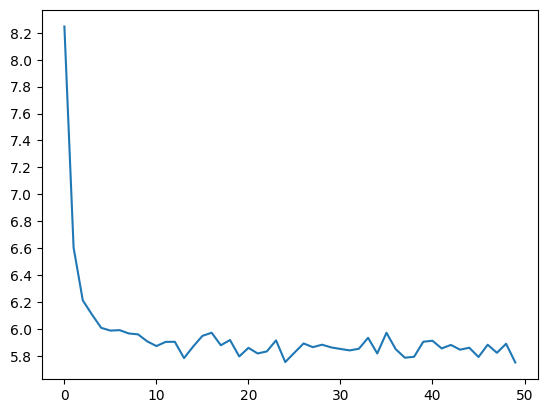

In [ ]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder1 = DecoderRNN(hidden_size, output_lang.n_words).to(device)

trainIters(encoder1, decoder1, 5000, print_every=1000)

In [ ]:
df3 = pd.read_csv("/content/drive/MyDrive/Cooking_Dataset/Cooking_Dataset/test.csv")
for x in range(len(df3['Recipe'])):
    if type(df3['Recipe'][x]) != str:
        print(df3['Recipe'][x])
        df3['Recipe'][x] = ''

with open("eng-fra3.txt", "w") as file:
    for index, row in df3.iterrows():
        file.write(f"{row['Recipe']}:::{row['Ingredients']}\n")


def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    file_name = file_path + 'eng-fra3.txt'
    lines = open(file_name, encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split(':::')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs


test_input_lang, test_output_lang, test_pairs = prepareData('eng', 'fra', True)
print(random.choice(test_pairs))

Reading lines...
Read 778 sentence pairs
Trimmed to 660 sentence pairs
Counting words...
Counted words:
fra 1771
eng 2881
[' tb finely chopped scallions or grreen onions with tops tb lime juice ts salt c cut up cooked chicken c cooked green peas c mayonnaise or salad dressing c finely chopped carrot c f nely chopped celery c f nely chopped fresh cilantro tb orange juice ts salt ts ground cinnamon ts freshlygrround pepper lettuce leaves oranges pared and sectioned avocados peeled and cut into wedges', 'mix scallions lime juice and teaspoon salt cover and refrigerate . mix remaining ingredients except lettuce oranges and avocados cover and refrigerate at least hour . spoon chicken mixture onto lettuce . garnish with oranges and avocados . sprinkle with scallions . servings .']


In [ ]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
def remove_stop_words(text):
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    filtered_text = ' '.join([word for word in word_tokens if word.lower() not in stop_words])
    return filtered_text
df3 = pd.read_csv("/content/drive/MyDrive/test.csv")
for x in range(len(df3['Recipe'])):
    if type(df3['Recipe'][x]) != str:
        df3['Recipe'][x] = ''
# Apply the function to the DataFrame columns
df3['Ingredients'] = df3['Ingredients'].apply(remove_stop_words)
df3['Recipe'] = df3['Recipe'].apply(remove_stop_words)

In [ ]:
with open("eng-fra3.txt", "w") as file:
    for index, row in df3.iterrows():
        file.write(f"{row['Recipe']}:::{row['Ingredients']}\n")

def readLangs(lang1, lang2, reverse=False, file_name='eng-fra3.txt'):
    print("Reading lines...")

    # Read the file and split into lines
    file_name = file_path + file_name
    lines = open(file_name, encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split(':::')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

def prepareData(lang1, lang2, reverse=False, file_name='eng-fra3.txt'):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse, file_name)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

def indexesFromSentence(lang, sentence):
    return [lang.word2index.get(word, UNK_token) for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long).view(-1, 1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

# Process test data
test_input_lang, test_output_lang, test_pairs = prepareData('eng', 'fra', True, 'eng-fra3.txt')
print(random.choice(test_pairs))

In [ ]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu
from tqdm import tqdm

def evaluate_bleu(encoder, decoder, test_pairs):
    references = []  # Stores reference sentences for each prediction
    hypotheses = []  # Stores predicted sentences

    for pair in tqdm(test_pairs):
        input_sentence = pair[0]
        target_sentence = pair[1]

        output_words = evaluate(encoder, decoder, input_sentence)
        output_sentence = ' '.join(output_words)

        # Removing <SOS> and <EOS> tokens from target_sentence
        target_sentence = target_sentence.split()
        if target_sentence[0] == "SOS":
            target_sentence = target_sentence[1:]
        if target_sentence[-1] == "EOS":
            target_sentence = target_sentence[:-1]

        references.append([target_sentence])
        hypotheses.append(output_words)

    bleu_score = corpus_bleu(references, hypotheses)
    return bleu_score

# Assuming you have test_pairs variable containing test data
encoder1 = encoder1.to(device)
decoder1 = decoder1.to(device)

bleu_score = evaluate_bleu(encoder1, decoder1, test_pairs)
print("BLEU-4 Score:", bleu_score)

In [ ]:
from nltk.translate.meteor_score import meteor_score
def evaluate_meteor(encoder, decoder, test_pairs):
    references = []  # Stores reference sentences for each prediction
    hypotheses = []  # Stores predicted sentences

    for pair in tqdm(test_pairs):
        input_sentence = pair[0]
        target_sentence = pair[1]

        output_words = evaluate(encoder, decoder, input_sentence)
        output_sentence = ' '.join(output_words)

        # Split reference sentence into tokens
        target_tokens = target_sentence.strip().split()

        references.append(target_tokens)
        hypotheses.append(output_sentence)

    meteor_avg = meteor_score(references, hypotheses)
    return meteor_avg

# Assuming you have test_pairs variable containing test data
meteor_score = evaluate_meteor(encoder1, decoder1, test_pairs)
print("METEOR Score:", meteor_score)


In [ ]:
def evaluate_accuracy(encoder, decoder, test_pairs):
    total_correct = 0
    total_items = 0

    for pair in tqdm(test_pairs):
        input_sentence = pair[0]
        target_sentence = pair[1]

        output_words = evaluate(encoder, decoder, input_sentence)
        output_sentence = ' '.join(output_words)

        # Tokenize target and output sentences for comparison
        target_tokens = target_sentence.strip().split()
        output_tokens = output_sentence.strip().split()

        # Calculate number of correctly predicted items
        correct_items = sum(1 for token in output_tokens if token in target_tokens)

        total_correct += correct_items
        total_items += len(target_tokens)

    avg_accuracy = (total_correct / total_items) * 100 if total_items > 0 else 0
    return avg_accuracy

# Assuming you have test_pairs variable containing test data
accuracy = evaluate_accuracy(encoder1, decoder1, test_pairs)
print("Average Accuracy (%):", accuracy)

In [ ]:
def evaluate_extra_items(encoder, decoder, test_pairs):
    total_extra_items = 0
    total_sentences = len(test_pairs)

    for pair in tqdm(test_pairs):
        input_sentence = pair[0]
        target_sentence = pair[1]

        output_words = evaluate(encoder, decoder, input_sentence)
        output_sentence = ' '.join(output_words)

        # Tokenize target and output sentences for comparison
        target_tokens = set(target_sentence.strip().split())
        output_tokens = set(output_sentence.strip().split())

        # Calculate number of extra predicted items
        extra_items = len(output_tokens - target_tokens)

        total_extra_items += extra_items

    avg_extra_items = total_extra_items / total_sentences if total_sentences > 0 else 0
    return avg_extra_items

# Assuming you have test_pairs variable containing test data
avg_extra_items = evaluate_extra_items(encoder1, decoder1, test_pairs)
print("Average Extra Items:", avg_extra_items)

In [ ]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words= evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [ ]:
sentence1 = ': 2 c sugar, 1/4 c lemon juice, 1 c water, 1/3 c orange juice, 8 c strawberries'
output_words= evaluate(encoder1, decoder1, sentence1)
output_sentence = ' '.join(output_words)
print('<', output_sentence)